2025-05-18 15:56:26.737844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747583786.938882      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747583786.998537      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading dataset...


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Creating model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning model...


Epoch 1/3: 100%|██████████| 563/563 [08:48<00:00,  1.07it/s]


Epoch 1/3, Average Loss: 0.0013
Validation - Loss: 0.0000, Accuracy: 1.0000


Epoch 2/3: 100%|██████████| 563/563 [08:59<00:00,  1.04it/s]


Epoch 2/3, Average Loss: 0.0000
Validation - Loss: 0.0000, Accuracy: 1.0000


Epoch 3/3: 100%|██████████| 563/563 [09:00<00:00,  1.04it/s]


Epoch 3/3, Average Loss: 0.0000
Validation - Loss: 0.0000, Accuracy: 1.0000
Identifying useless parameters...


Gradient Analysis: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s]


Visualizing results...
Total parameters: 124,441,344
Identified useless parameters: 120,038,573 (96.46%)


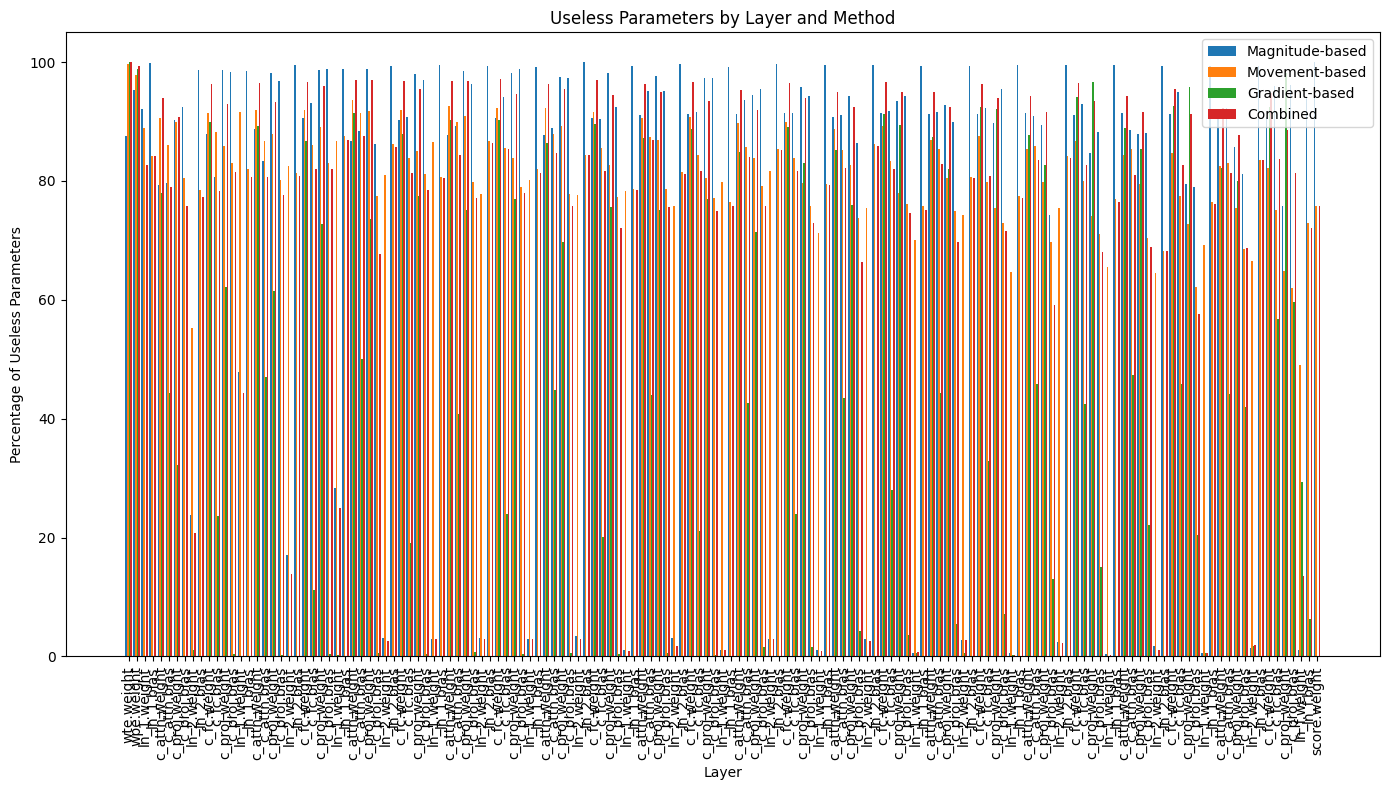

Magnitude threshold: 0.217119
Movement threshold: 0.000501
Gradient threshold: 0.000000

Top 10 layers with highest percentage of useless parameters:
1. transformer.wte.weight: 99.96% useless
2. transformer.wpe.weight: 99.27% useless
3. transformer.h.3.mlp.c_fc.weight: 97.14% useless
4. transformer.h.2.attn.c_attn.weight: 97.04% useless
5. transformer.h.4.mlp.c_fc.weight: 96.93% useless
6. transformer.h.2.attn.c_proj.weight: 96.93% useless
7. transformer.h.3.attn.c_attn.weight: 96.89% useless
8. transformer.h.2.mlp.c_fc.weight: 96.82% useless
9. transformer.h.3.attn.c_proj.weight: 96.76% useless
10. transformer.h.1.mlp.c_fc.weight: 96.70% useless

Analysis complete. Model and useless parameters saved for future unlearning.


In [1]:
import torch
import numpy as np
from transformers import GPT2Model, GPT2Config, GPT2ForSequenceClassification, GPT2Tokenizer
from transformers import  get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Load and prepare dataset (using IMDb for sentiment analysis)
def prepare_dataset():
    print("Loading dataset...")
    dataset = load_dataset("imdb")
    
    # Create a custom dataset class for easier handling
    class IMDbDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
            
        def __len__(self):
            return len(self.labels)
            
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            
            # Tokenize the text
            encoding = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            
            # Convert to the expected format
            input_ids = encoding["input_ids"].squeeze()
            attention_mask = encoding["attention_mask"].squeeze()
            
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)
            }
    
    # Setup tokenizer with proper padding
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Create train and validation sets
    train_texts = dataset["train"]["text"][:5000]  # Using a subset for faster training
    train_labels = dataset["train"]["label"][:5000]
    
    # Create dataset with pre-tokenized inputs
    train_dataset = IMDbDataset(train_texts, train_labels, tokenizer)
    
    # Split into train and validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    return train_dataset, val_dataset, tokenizer

# 2. Define model and tokenizer
def create_model(tokenizer, num_labels=2):
    print("Creating model...")
    # Load pre-trained GPT-2 (small version)
    config = GPT2Config.from_pretrained("gpt2", num_labels=num_labels)
    model = GPT2ForSequenceClassification.from_pretrained("gpt2", config=config)
    
    # Set pad token id in the model config
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Save the initial model state for later comparison
    initial_state = {name: param.clone().detach() for name, param in model.named_parameters()}
    
    return model, initial_state

# 3. Fine-tune the model
def finetune_model(model, train_dataset, val_dataset, epochs=3, batch_size=8):
    print("Fine-tuning model...")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                
                outputs = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["labels"]
                )
                
                val_loss += outputs.loss.item()
                
                # Get predictions
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == batch["labels"]).sum().item()
                total += batch["labels"].size(0)
        
        val_accuracy = correct / total
        print(f"Validation - Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}")
    
    return model, val_loader

# 4. Identify useless parameters using multiple methods
def identify_useless_parameters(model, initial_state, val_loader):
    print("Identifying useless parameters...")
    device = next(model.parameters()).device
    
    # Method 1: Magnitude-based pruning
    def magnitude_based_pruning(model, percentile=90):
        param_magnitudes = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                param_magnitudes[name] = torch.abs(param).detach().cpu().numpy().flatten()
        
        # Calculate threshold based on percentile
        all_magnitudes = np.concatenate([mag for mag in param_magnitudes.values()])
        threshold = np.percentile(all_magnitudes, percentile)
        
        useless_params = {}
        for name, magnitudes in param_magnitudes.items():
            useless_params[name] = magnitudes < threshold
        
        return useless_params, threshold
    
    # Method 2: Movement-based analysis
    def movement_based_analysis(model, initial_state, percentile=90):
        param_movements = {}
        for name, param in model.named_parameters():
            if param.requires_grad and name in initial_state:
                movement = torch.abs(param - initial_state[name].to(param.device)).detach().cpu().numpy().flatten()
                param_movements[name] = movement
        
        # Calculate threshold based on percentile
        all_movements = np.concatenate([mov for mov in param_movements.values()])
        threshold = np.percentile(all_movements, percentile)
        
        useless_params = {}
        for name, movements in param_movements.items():
            useless_params[name] = movements < threshold
        
        return useless_params, threshold
    
    # Method 3: Gradient-based analysis
    def gradient_based_analysis(model, val_loader, percentile=90):
        # Initialize gradient accumulation
        grad_accumulation = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                grad_accumulation[name] = torch.zeros_like(param)
        
        # Accumulate gradients over validation set
        model.eval()
        num_samples = 0
        
        for batch in tqdm(val_loader, desc="Gradient Analysis"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            model.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            
            loss = outputs.loss
            loss.backward()
            
            # Accumulate absolute gradients
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    grad_accumulation[name] += torch.abs(param.grad).detach()
            
            num_samples += 1
        
        # Average gradients
        for name in grad_accumulation:
            grad_accumulation[name] /= num_samples
            
        # Convert to numpy and flatten
        grad_magnitudes = {name: grad.cpu().numpy().flatten() for name, grad in grad_accumulation.items()}
        
        # Calculate threshold based on percentile
        all_grads = np.concatenate([grad for grad in grad_magnitudes.values()])
        threshold = np.percentile(all_grads, percentile)
        
        useless_params = {}
        for name, grads in grad_magnitudes.items():
            useless_params[name] = grads < threshold
        
        return useless_params, threshold
    
    # Apply all methods
    magnitude_results, mag_threshold = magnitude_based_pruning(model)
    movement_results, mov_threshold = movement_based_analysis(model, initial_state)
    gradient_results, grad_threshold = gradient_based_analysis(model, val_loader)
    
    # Combine results (a parameter is considered useless if identified by at least 2 methods)
    combined_results = {}
    parameter_stats = {}
    
    for name in magnitude_results:
        if name in movement_results and name in gradient_results:
            # Calculate percentage of parameters identified as useless by each method
            mag_percent = np.mean(magnitude_results[name]) * 100
            mov_percent = np.mean(movement_results[name]) * 100
            grad_percent = np.mean(gradient_results[name]) * 100
            
            # Parameter is useless if identified by at least 2 methods
            combined_mask = (magnitude_results[name].astype(int) + 
                            movement_results[name].astype(int) + 
                            gradient_results[name].astype(int)) >= 2
            
            combined_results[name] = combined_mask
            parameter_stats[name] = {
                "magnitude_percent": mag_percent,
                "movement_percent": mov_percent,
                "gradient_percent": grad_percent,
                "combined_percent": np.mean(combined_mask) * 100
            }
    
    return combined_results, parameter_stats, (mag_threshold, mov_threshold, grad_threshold)

# 5. Visualize results
def visualize_results(model, parameter_stats, thresholds):
    print("Visualizing results...")
    # Calculate total parameters and useless parameters
    total_params = 0
    useless_params = 0
    
    for name, stats in parameter_stats.items():
        param_size = np.prod(model.state_dict()[name].shape)
        total_params += param_size
        useless_params += int(stats["combined_percent"] * param_size / 100)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Identified useless parameters: {useless_params:,} ({useless_params/total_params*100:.2f}%)")
    
    # Plot percentage of useless parameters by layer
    plt.figure(figsize=(14, 8))
    
    layer_names = list(parameter_stats.keys())
    magnitude_pct = [stats["magnitude_percent"] for stats in parameter_stats.values()]
    movement_pct = [stats["movement_percent"] for stats in parameter_stats.values()]
    gradient_pct = [stats["gradient_percent"] for stats in parameter_stats.values()]
    combined_pct = [stats["combined_percent"] for stats in parameter_stats.values()]
    
    # Shorten layer names for display
    short_names = [name.split('.')[-2] + '.' + name.split('.')[-1] if len(name.split('.')) > 2 else name for name in layer_names]
    
    x = np.arange(len(short_names))
    width = 0.2
    
    plt.bar(x - width*1.5, magnitude_pct, width, label='Magnitude-based')
    plt.bar(x - width/2, movement_pct, width, label='Movement-based')
    plt.bar(x + width/2, gradient_pct, width, label='Gradient-based')
    plt.bar(x + width*1.5, combined_pct, width, label='Combined')
    
    plt.xlabel('Layer')
    plt.ylabel('Percentage of Useless Parameters')
    plt.title('Useless Parameters by Layer and Method')
    plt.xticks(x, short_names, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig('useless_parameters_by_layer.png')
    plt.show()
    
    # Print thresholds
    print(f"Magnitude threshold: {thresholds[0]:.6f}")
    print(f"Movement threshold: {thresholds[1]:.6f}")
    print(f"Gradient threshold: {thresholds[2]:.6f}")
    
    return useless_params, total_params

# Main execution
if __name__ == "__main__":
    # Step 1: Prepare dataset
    train_dataset, val_dataset, tokenizer = prepare_dataset()
    
    # Step 2: Create model
    model, initial_state = create_model(tokenizer)
    
    # Step 3: Fine-tune model
    model, val_loader = finetune_model(model, train_dataset, val_dataset)
    
    # Step 4: Identify useless parameters
    useless_params, parameter_stats, thresholds = identify_useless_parameters(model, initial_state, val_loader)
    
    # Step 5: Visualize results
    useless_count, total_count = visualize_results(model, parameter_stats, thresholds)
    
    print("\nTop 10 layers with highest percentage of useless parameters:")
    sorted_stats = sorted(parameter_stats.items(), key=lambda x: x[1]["combined_percent"], reverse=True)
    for i, (name, stats) in enumerate(sorted_stats[:10]):
        print(f"{i+1}. {name}: {stats['combined_percent']:.2f}% useless")
    
    # Save model for later unlearning
    torch.save({
        'model_state_dict': model.state_dict(),
        'useless_params': useless_params,
        'parameter_stats': parameter_stats
    }, 'gpt2_model_with_useless_params.pt')
    
    print("\nAnalysis complete. Model and useless parameters saved for future unlearning.")

Loading dataset...
Loading model and useless parameters...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters before pruning: 124,441,344
Pruned 120,038,606 parameters (96.46% of total)

Evaluating original model...
Evaluating Original Model...


Evaluation of Original Model: 100%|██████████| 63/63 [00:37<00:00,  1.69it/s]


Original Model Performance:
- Accuracy: 1.0000
- Average Inference Time: 545.71 ms per batch
- Model Parameter Memory: 486.71 MB
- CPU Memory Usage: -475.18 MB
- GPU Memory Usage: 6508.35 MB

Evaluating pruned model...
Evaluating Pruned Model...


Evaluation of Pruned Model: 100%|██████████| 63/63 [00:38<00:00,  1.64it/s]


Pruned Model Performance:
- Accuracy: 1.0000
- Average Inference Time: 575.19 ms per batch
- Model Parameter Memory: 486.71 MB
- CPU Memory Usage: -475.33 MB
- GPU Memory Usage: 4218.39 MB
Creating visualizations...


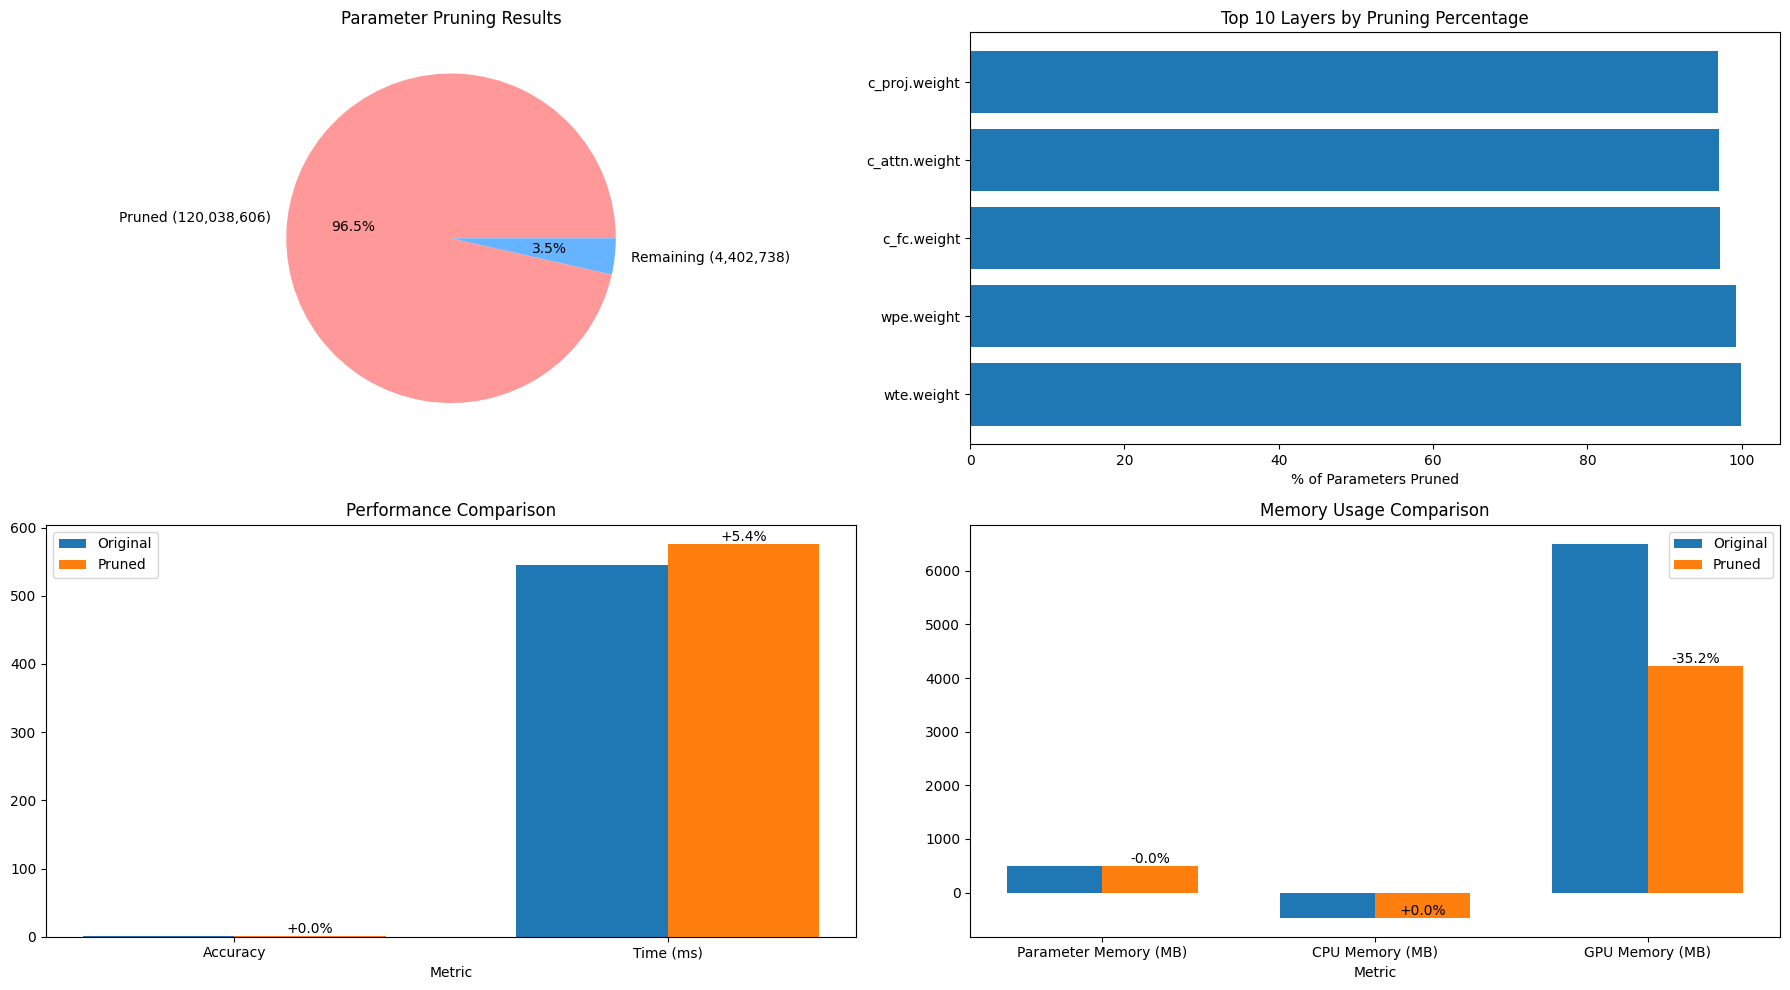


===== Performance Comparison Summary =====
Metric                        Original       Pruned       Change
---------------------------------------------------------------
Accuracy                        1.0000       1.0000 +       0.00%
Inference Time (ms)             545.71       575.19 +       5.40%
Parameter Memory (MB)           486.71       486.71 -       0.00%
CPU Memory (MB)                -475.18      -475.33 +       0.03%
GPU Memory (MB)                6508.35      4218.39 -      35.18%
Saving pruned model...

Pruning summary:
- Total parameters: 124,441,344
- Pruned parameters: 120,038,606 (96.46%)
- Original model accuracy: 1.0000
- Pruned model accuracy: 1.0000

Pruned model saved as 'gpt2_pruned_model.pt'


In [4]:
import torch
import numpy as np
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import psutil
import gc

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def load_dataset_and_tokenizer():
    """Recreate the dataset and tokenizer"""
    print("Loading dataset...")
    dataset = load_dataset("imdb")
    
    # Create a custom dataset class for easier handling
    class IMDbDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
            
        def __len__(self):
            return len(self.labels)
            
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            
            # Tokenize the text
            encoding = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            
            # Convert to the expected format
            input_ids = encoding["input_ids"].squeeze()
            attention_mask = encoding["attention_mask"].squeeze()
            
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)
            }
    
    # Setup tokenizer with proper padding
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Create test set for evaluation (using subset not used during training)
    test_texts = dataset["test"]["text"][:1000]  # Using 1000 samples for testing
    test_labels = dataset["test"]["label"][:1000]
    
    # Create dataset with pre-tokenized inputs
    test_dataset = IMDbDataset(test_texts, test_labels, tokenizer)
    
    return test_dataset, tokenizer

def load_model_and_prune_useless_parameters():
    """Load the saved model and apply pruning to useless parameters"""
    print("Loading model and useless parameters...")
    
    # Load the saved model data
    saved_data = torch.load('gpt2_model_with_useless_params.pt', weights_only=False)
    model_state_dict = saved_data['model_state_dict']
    useless_params = saved_data['useless_params']
    parameter_stats = saved_data['parameter_stats']
    
    # Load the model architecture
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Apply the saved state dict
    model.load_state_dict(model_state_dict)
    
    # Save a copy of the original model for comparison
    original_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
    original_model.config.pad_token_id = tokenizer.pad_token_id
    original_model.load_state_dict(model_state_dict)
    
    # Count parameters before pruning
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters before pruning: {total_params:,}")
    
    # Apply pruning by setting useless parameters to zero
    pruned_count = 0
    for name, mask in useless_params.items():
        if name in model_state_dict:
            # Convert mask to proper shape and device
            param = model_state_dict[name]
            mask_tensor = torch.tensor(mask, dtype=torch.bool).to(param.device)
            
            # Reshape mask if needed to match parameter shape
            if mask_tensor.shape != param.shape:
                mask_tensor = mask_tensor.reshape(param.shape)
            
            # Create a copy of the parameter values
            modified_param = param.clone()
            
            # Set useless parameters to zero
            modified_param[mask_tensor] = 0.0
            
            # Update the parameter
            param.copy_(modified_param)
            
            # Count pruned parameters
            pruned_count += torch.sum(mask_tensor).item()
    
    print(f"Pruned {pruned_count:,} parameters ({pruned_count/total_params*100:.2f}% of total)")
    
    return model, original_model, parameter_stats, pruned_count, total_params

def get_memory_usage(model):
    """Get memory usage of a model in MB"""
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs  # in bytes
    return mem / 1024**2  # Convert to MB

def evaluate_model(model, test_dataset, model_name="Model", batch_size=16):
    """Evaluate the model after pruning"""
    print(f"Evaluating {model_name}...")
    
    # Measure memory usage
    memory_usage = get_memory_usage(model)
    process = psutil.Process()
    cpu_memory_before = process.memory_info().rss / 1024**2  # MB
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    correct = 0
    total = 0
    inference_times = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluation of {model_name}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Measure inference time
            start_time = time.time()
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            if device.type == "cuda": torch.cuda.synchronize()
            end_time = time.time()
            inference_times.append(end_time - start_time)
            
            # Get predictions
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            
            # Accumulate results
            correct += (predictions == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    
    accuracy = correct / total
    avg_inference_time = sum(inference_times) / len(inference_times)
    
    # Get peak GPU memory if applicable
    gpu_memory = 0
    if device.type == "cuda":
        gpu_memory = torch.cuda.max_memory_allocated(device) / 1024**2  # MB
        torch.cuda.reset_peak_memory_stats(device)
    
    # Get CPU memory usage
    cpu_memory_after = process.memory_info().rss / 1024**2
    cpu_memory_used = cpu_memory_after - cpu_memory_before
    
    print(f"{model_name} Performance:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- Average Inference Time: {avg_inference_time*1000:.2f} ms per batch")
    print(f"- Model Parameter Memory: {memory_usage:.2f} MB")
    print(f"- CPU Memory Usage: {cpu_memory_used:.2f} MB")
    if gpu_memory > 0:
        print(f"- GPU Memory Usage: {gpu_memory:.2f} MB")
    
    # Clean up to avoid memory issues
    model.to("cpu")
    if device.type == "cuda":
        torch.cuda.empty_cache()
    gc.collect()
    
    return {
        "accuracy": accuracy,
        "avg_inference_time": avg_inference_time,
        "memory_usage": memory_usage,
        "cpu_memory": cpu_memory_used,
        "gpu_memory": gpu_memory
    }

def compare_and_visualize(original_metrics, pruned_metrics, parameter_stats, pruned_count, total_params):
    """Visualize pruning results by layer and compare performance metrics"""
    print("Creating visualizations...")
    
    # Calculate pruning percentage by layer
    pruning_by_layer = {}
    for name, stats in parameter_stats.items():
        pruning_by_layer[name] = stats["combined_percent"]
    
    # Sort layers by pruning percentage for better visualization
    sorted_layers = sorted(pruning_by_layer.items(), key=lambda x: x[1], reverse=True)
    
    # Create figure with subplots
    plt.figure(figsize=(18, 10))
    
    # Plot 1: Parameter distribution (Pie chart)
    plt.subplot(2, 2, 1)
    remaining = total_params - pruned_count
    plt.pie([pruned_count, remaining], 
            labels=[f'Pruned ({pruned_count:,})', f'Remaining ({remaining:,})'], 
            autopct='%1.1f%%',
            colors=['#ff9999','#66b3ff'])
    plt.title('Parameter Pruning Results')
    
    # Plot 2: Top 10 layers by pruning percentage
    plt.subplot(2, 2, 2)
    top_layers = sorted_layers[:10]
    plt.barh([name.split('.')[-2] + '.' + name.split('.')[-1] if len(name.split('.')) > 2 else name 
             for name, _ in top_layers],
             [pct for _, pct in top_layers])
    plt.xlabel('% of Parameters Pruned')
    plt.title('Top 10 Layers by Pruning Percentage')
    
    # Plot 3: Performance comparison - Accuracy and Time
    plt.subplot(2, 2, 3)
    metrics = ['Accuracy', 'Time (ms)']
    original_values = [original_metrics['accuracy'], original_metrics['avg_inference_time']*1000]
    pruned_values = [pruned_metrics['accuracy'], pruned_metrics['avg_inference_time']*1000]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, original_values, width, label='Original')
    plt.bar(x + width/2, pruned_values, width, label='Pruned')
    
    # Add percentage change labels
    for i in range(len(metrics)):
        if metrics[i] == 'Accuracy':
            pct_change = (pruned_values[i] - original_values[i]) / original_values[i] * 100
            change_sign = '+' if pct_change >= 0 else ''
            plt.text(i + width/2, pruned_values[i], f"{change_sign}{pct_change:.1f}%", 
                    ha='center', va='bottom')
        else:
            pct_change = (original_values[i] - pruned_values[i]) / original_values[i] * 100
            change_sign = '-' if pct_change >= 0 else '+'
            abs_change = abs(pct_change)
            plt.text(i + width/2, pruned_values[i], f"{change_sign}{abs_change:.1f}%", 
                    ha='center', va='bottom')
    
    plt.xlabel('Metric')
    plt.xticks(x, metrics)
    plt.title('Performance Comparison')
    plt.legend()
    
    # Plot 4: Memory usage comparison
    plt.subplot(2, 2, 4)
    memory_metrics = ['Parameter Memory (MB)', 'CPU Memory (MB)']
    if original_metrics['gpu_memory'] > 0:
        memory_metrics.append('GPU Memory (MB)')
        
    original_memory = [original_metrics['memory_usage'], original_metrics['cpu_memory']]
    pruned_memory = [pruned_metrics['memory_usage'], pruned_metrics['cpu_memory']]
    
    if original_metrics['gpu_memory'] > 0:
        original_memory.append(original_metrics['gpu_memory'])
        pruned_memory.append(pruned_metrics['gpu_memory'])
    
    x = np.arange(len(memory_metrics))
    
    plt.bar(x - width/2, original_memory, width, label='Original')
    plt.bar(x + width/2, pruned_memory, width, label='Pruned')
    
    # Add percentage change labels
    for i in range(len(memory_metrics)):
        pct_change = (original_memory[i] - pruned_memory[i]) / original_memory[i] * 100
        change_sign = '-' if pct_change >= 0 else '+'
        abs_change = abs(pct_change)
        plt.text(i + width/2, pruned_memory[i], f"{change_sign}{abs_change:.1f}%", 
                ha='center', va='bottom')
    
    plt.xlabel('Metric')
    plt.xticks(x, memory_metrics)
    plt.title('Memory Usage Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pruning_performance_comparison.png')
    plt.show()
    
    # Print a summary table
    print("\n===== Performance Comparison Summary =====")
    print(f"{'Metric':<25} {'Original':>12} {'Pruned':>12} {'Change':>12}")
    print("-" * 63)
    
    # Accuracy
    acc_change = (pruned_metrics['accuracy'] - original_metrics['accuracy']) / original_metrics['accuracy'] * 100
    acc_sign = "+" if acc_change >= 0 else ""
    print(f"{'Accuracy':<25} {original_metrics['accuracy']:>12.4f} {pruned_metrics['accuracy']:>12.4f} {acc_sign}{acc_change:>11.2f}%")
    
    # Inference Time
    time_orig = original_metrics['avg_inference_time'] * 1000  # convert to ms
    time_pruned = pruned_metrics['avg_inference_time'] * 1000  # convert to ms
    time_change = (original_metrics['avg_inference_time'] - pruned_metrics['avg_inference_time']) / original_metrics['avg_inference_time'] * 100
    time_sign = "-" if time_change >= 0 else "+"
    print(f"{'Inference Time (ms)':<25} {time_orig:>12.2f} {time_pruned:>12.2f} {time_sign}{abs(time_change):>11.2f}%")
    
    # Parameter Memory
    mem_change = (original_metrics['memory_usage'] - pruned_metrics['memory_usage']) / original_metrics['memory_usage'] * 100
    mem_sign = "-" if mem_change >= 0 else "+"
    print(f"{'Parameter Memory (MB)':<25} {original_metrics['memory_usage']:>12.2f} {pruned_metrics['memory_usage']:>12.2f} {mem_sign}{abs(mem_change):>11.2f}%")
    
    # CPU Memory
    cpu_change = (original_metrics['cpu_memory'] - pruned_metrics['cpu_memory']) / original_metrics['cpu_memory'] * 100
    cpu_sign = "-" if cpu_change >= 0 else "+"
    print(f"{'CPU Memory (MB)':<25} {original_metrics['cpu_memory']:>12.2f} {pruned_metrics['cpu_memory']:>12.2f} {cpu_sign}{abs(cpu_change):>11.2f}%")
    
    # GPU Memory (if applicable)
    if original_metrics['gpu_memory'] > 0:
        gpu_change = (original_metrics['gpu_memory'] - pruned_metrics['gpu_memory']) / original_metrics['gpu_memory'] * 100
        gpu_sign = "-" if gpu_change >= 0 else "+"
        print(f"{'GPU Memory (MB)':<25} {original_metrics['gpu_memory']:>12.2f} {pruned_metrics['gpu_memory']:>12.2f} {gpu_sign}{abs(gpu_change):>11.2f}%")

def save_pruned_model(model, accuracy):
    """Save the pruned model for future use"""
    print("Saving pruned model...")
    
    # Save the pruned model
    torch.save({
        'model_state_dict': model.state_dict(),
        'test_accuracy': accuracy
    }, 'gpt2_pruned_model.pt')

def main():
    """Main execution function"""
    # Load dataset for evaluation
    test_dataset, tokenizer = load_dataset_and_tokenizer()
    
    # Load model and prune useless parameters
    pruned_model, original_model, parameter_stats, pruned_count, total_params = load_model_and_prune_useless_parameters()
    
    # Evaluate the original model
    print("\nEvaluating original model...")
    original_metrics = evaluate_model(original_model, test_dataset, model_name="Original Model")
    
    # Evaluate the pruned model
    print("\nEvaluating pruned model...")
    pruned_metrics = evaluate_model(pruned_model, test_dataset, model_name="Pruned Model")
    
    # Compare and visualize results
    compare_and_visualize(original_metrics, pruned_metrics, parameter_stats, pruned_count, total_params)
    
    # Save the pruned model
    save_pruned_model(pruned_model, pruned_metrics['accuracy'])
    
    print(f"\nPruning summary:")
    print(f"- Total parameters: {total_params:,}")
    print(f"- Pruned parameters: {pruned_count:,} ({pruned_count/total_params*100:.2f}%)")
    print(f"- Original model accuracy: {original_metrics['accuracy']:.4f}")
    print(f"- Pruned model accuracy: {pruned_metrics['accuracy']:.4f}")
    print("\nPruned model saved as 'gpt2_pruned_model.pt'")

if __name__ == "__main__":
    main()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Config, PretrainedConfig # Using PretrainedConfig for flexibility
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention as HFGPT2Attention # For reference
from transformers.models.gpt2.modeling_gpt2 import GPT2MLP as HFGPT2MLP # For reference
from transformers.activations import ACT2FN
import numpy as np
from copy import deepcopy
import math # For math.sqrt

# --- SparseLinear Layer ---
class SparseLinear(nn.Module):
    """
    A sparse linear layer that stores weights in a sparse COO format.
    It mimics torch.nn.Linear but is designed for sparse weight matrices.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # The sparse_weight is a Parameter holding a sparse_coo_tensor.
        # It's initialized as None and set by `set_weights` or `from_dense`.
        self.sparse_weight = None 
                                 
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def set_weights(self, sparse_weight_tensor: torch.Tensor, bias_tensor: torch.Tensor = None):
        if not sparse_weight_tensor.is_sparse:
            raise ValueError("Weight tensor must be in sparse COO format.")
        if sparse_weight_tensor.shape != (self.out_features, self.in_features):
            raise ValueError(
                f"Expected sparse weight shape {(self.out_features, self.in_features)}, "
                f"got {sparse_weight_tensor.shape}"
            )
        
        # Ensure the sparse weight tensor is coalesced
        _sparse_weight_tensor = sparse_weight_tensor.coalesce() # *** MODIFY THIS PART ***
        self.sparse_weight = nn.Parameter(_sparse_weight_tensor) # Use the coalesced tensor
        
        if self.bias is not None and bias_tensor is not None:
            if bias_tensor.shape != (self.out_features,):
                 raise ValueError(f"Expected bias shape {(self.out_features,)}, got {bias_tensor.shape}")
            self.bias.data = bias_tensor.clone()
        elif self.bias is not None and bias_tensor is None:
            nn.init.zeros_(self.bias)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.sparse_weight is None:
            raise RuntimeError(f"SparseLinear weights not set for layer: {self}")
        
        # --- Debug prints can remain if helpful ---
        # print(f"\n--- Debug: SparseLinear.forward() for layer: {self} ---")
        # print(f"  Input 'x' -> shape: {x.shape}, dtype: {x.dtype}, device: {x.device}, is_sparse: {x.is_sparse}")
        # if self.sparse_weight is not None:
        #     print(f"  Weight 'self.sparse_weight' -> shape: {self.sparse_weight.shape}, dtype: {self.sparse_weight.dtype}, device: {self.sparse_weight.device}, "
        #           f"is_sparse: {self.sparse_weight.is_sparse}, layout: {self.sparse_weight.layout}")
        #     if self.sparse_weight.is_sparse:
        #         print(f"    _nnz(): {self.sparse_weight._nnz()}, sparse_dim(): {self.sparse_weight.sparse_dim()}, dense_dim(): {self.sparse_weight.dense_dim()}")
        #         if self.sparse_weight._nnz() > 0:
        #             print(f"    _indices() shape: {self.sparse_weight._indices().shape}, dtype: {self.sparse_weight._indices().dtype}")
        #             print(f"    _values() shape: {self.sparse_weight._values().shape}, dtype: {self.sparse_weight._values().dtype}")
        #         else:
        #             print(f"    _indices() shape: {self.sparse_weight._indices().shape} (Note: nnz is 0)")
        #             print(f"    _values() shape: {self.sparse_weight._values().shape} (Note: nnz is 0)")
        # if self.bias is not None:
        #     print(f"  Bias 'self.bias' -> shape: {self.bias.shape}, dtype: {self.bias.dtype}, device: {self.bias.device}")
        # else:
        #     print(f"  Bias 'self.bias' is None.")
    
        try:
            if self.sparse_weight.is_sparse:
                if x.dim() > 2:
                    # For batched inputs, reshape and use sparse multiplication for each item in batch
                    batch_size = x.size(0)
                    # Need to handle this with a different approach for sparse tensors
                    output_slices = []
                    for i in range(batch_size):
                        # Make sure x[i] is correctly shaped for sparse multiplication
                        output_slice = torch.sparse.mm(self.sparse_weight, x[i].t()).t()
                        if self.bias is not None:
                            output_slice = output_slice + self.bias
                        output_slices.append(output_slice)
                    output = torch.stack(output_slices, dim=0)
                else:
                    # For 2D input, use sparse matrix multiplication directly
                    output = torch.sparse.mm(self.sparse_weight, x.t()).t()
                    if self.bias is not None:
                        output = output + self.bias
            else:
                # Fallback for dense weights
                output = F.linear(x, self.sparse_weight, self.bias)
        
        except RuntimeError as e:
            # print(f"!!! RuntimeError in sparse multiplication for {self}: {e}")
            raise e  # Re-throw the exception
    
        return output

    @staticmethod
    def from_dense(dense_weight: torch.Tensor, 
                   weight_mask: torch.Tensor, 
                   dense_bias: torch.Tensor = None, 
                   transpose_weight: bool = False) -> 'SparseLinear':
        
        _final_dense_weight = dense_weight.clone().float()
    
        if transpose_weight:
            _final_dense_weight = _final_dense_weight.t()
        
        _reshaped_weight_mask = weight_mask.clone()
    
        if _reshaped_weight_mask.ndim == 1 and _reshaped_weight_mask.numel() == _final_dense_weight.numel():
            _reshaped_weight_mask = _reshaped_weight_mask.reshape(_final_dense_weight.shape)
        elif _reshaped_weight_mask.shape != _final_dense_weight.shape:
            raise ValueError(
                f"Mask shape {_reshaped_weight_mask.shape} (numel: {_reshaped_weight_mask.numel()}) "
                f"is incompatible with the target weight shape {_final_dense_weight.shape} "
                f"(numel: {_final_dense_weight.numel()}). Original dense_weight shape was {dense_weight.shape}, transpose_weight={transpose_weight}."
            )
    
        _final_dense_weight[_reshaped_weight_mask] = 0.0 
        
        out_features, in_features = _final_dense_weight.shape
        current_device = _final_dense_weight.device
        
        # Ensure we get proper 2D indices and values
        indices = torch.nonzero(_final_dense_weight, as_tuple=False).t()
        values = _final_dense_weight[(_final_dense_weight != 0)]
        
        indices = indices.to(current_device)
        values = values.to(current_device)
    
        sparse_weight_tensor = torch.sparse_coo_tensor(
            indices, 
            values, 
            _final_dense_weight.shape, 
            device=current_device
        ).coalesce()  # Always coalesce
        
        layer = SparseLinear(in_features, out_features, bias=(dense_bias is not None))
        
        final_bias_for_set_weights = None
        if dense_bias is not None:
            final_bias_for_set_weights = dense_bias.clone().float() 
    
        layer.set_weights(sparse_weight_tensor, final_bias_for_set_weights)
        return layer

    def __repr__(self):
        return (f"SparseLinear(in_features={self.in_features}, out_features={self.out_features}, "
                f"bias={self.bias is not None}, nnz={self.sparse_weight._nnz() if self.sparse_weight is not None else 'N/A'})")

# --- Sparse GPT-2 Components ---
class SparseGPT2Attention(nn.Module):
    def __init__(self, config: GPT2Config, layer_idx: int = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        
        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(torch.ones((max_positions, max_positions), dtype=torch.uint8)).view(
                1, 1, max_positions, max_positions
            ),
            persistent=False, 
        )


        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"`embed_dim` must be divisible by `num_heads` (got `embed_dim`: {self.embed_dim} and `num_heads`: {self.num_heads})."
            )

        self.scale_attn_weights = config.scale_attn_weights
        
        self.c_attn = None 
        self.c_proj = None 

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        self.pruned_heads = set()

    def _attn(self, query, key, value, attention_mask=None, head_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))

        if self.scale_attn_weights:
            attn_weights = attn_weights / (float(value.size(-1)) ** 0.5)

        query_length, key_length = query.size(-2), key.size(-2)
        causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length].to(torch.bool)
        attn_weights = torch.where(causal_mask, attn_weights, torch.tensor(float("-inf")).to(attn_weights.device))


        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)
        return attn_output, attn_weights

    def _split_heads(self, tensor, num_heads, attn_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(new_shape)
        return tensor.permute(0, 2, 1, 3)

    def _merge_heads(self, tensor, num_heads, attn_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(self, hidden_states, layer_past=None, attention_mask=None, head_mask=None, use_cache=False, output_attentions=False):
        if self.c_attn is None or self.c_proj is None:
            raise RuntimeError("SparseGPT2Attention layers (c_attn, c_proj) not initialized.")

        query_key_value = self.c_attn(hidden_states)
        query, key, value = query_key_value.split(self.split_size, dim=2)

        query = self._split_heads(query, self.num_heads, self.head_dim)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)
        
        if layer_past is not None:
            past_key, past_value = layer_past
            key = torch.cat((past_key, key), dim=-2)
            value = torch.cat((past_value, value), dim=-2)

        if use_cache is True:
            present = (key, value)
        else:
            present = None

        attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        outputs = (attn_output, present)
        if output_attentions:
            outputs += (attn_weights,)
        
        return outputs

class SparseGPT2MLP(nn.Module):
    def __init__(self, intermediate_size: int, config: GPT2Config):
        super().__init__()
        embed_dim = config.hidden_size
        self.c_fc = None 
        self.c_proj = None 
        self.act = ACT2FN[config.activation_function]
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        if self.c_fc is None or self.c_proj is None:
            raise RuntimeError("SparseGPT2MLP layers (c_fc, c_proj) not initialized.")
        hidden_states = self.c_fc(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.c_proj(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states

class SparseGPT2Block(nn.Module):
    def __init__(self, config: GPT2Config, layer_idx: int = None):
        super().__init__()
        hidden_size = config.hidden_size
        intermediate_size = config.intermediate_size if hasattr(config, 'intermediate_size') else config.n_inner
        if intermediate_size is None: intermediate_size = 4 * hidden_size


        self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.attn = SparseGPT2Attention(config, layer_idx=layer_idx)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.mlp = SparseGPT2MLP(intermediate_size, config)

    def forward(self, hidden_states, layer_past=None, attention_mask=None, head_mask=None, use_cache=False, output_attentions=False):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask, 
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]
        outputs = attn_outputs[1:]
        
        hidden_states = attn_output + residual

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        hidden_states = residual + feed_forward_hidden_states

        if use_cache:
            outputs = (hidden_states,) + outputs
        else:
            outputs = (hidden_states,) + outputs[1:]

        return outputs

class SparseGPT2Model(nn.Module):
    def __init__(self, config: GPT2Config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size

        self.wte = nn.Embedding(config.vocab_size, self.embed_dim)
        self.wpe = nn.Embedding(config.max_position_embeddings, self.embed_dim)

        self.drop = nn.Dropout(config.embd_pdrop)
        self.h = nn.ModuleList([SparseGPT2Block(config, layer_idx=i) for i in range(config.num_hidden_layers)])
        self.ln_f = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_epsilon)
        
        self.model_parallel = False 

    def get_input_embeddings(self):
        return self.wte

    def set_input_embeddings(self, new_embeddings):
        self.wte = new_embeddings

    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None, 
        inputs_embeds=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
            batch_size = input_ids.shape[0]
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size = inputs_embeds.shape[0]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, input_shape[-1])
        if position_ids is not None:
            position_ids = position_ids.view(-1, input_shape[-1])

        if past_key_values is None:
            past_length = 0
            past_key_values = tuple([None] * len(self.h))
        else:
            past_length = past_key_values[0][0].size(-2)

        if position_ids is None:
            position_ids = torch.arange(past_length, input_shape[-1] + past_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])

        if attention_mask is not None:
            if batch_size <= 0:
                raise ValueError("batch_size has to be defined and > 0")
            attention_mask = attention_mask.view(batch_size, -1)
            attention_mask = attention_mask[:, None, None, :]
            attention_mask = attention_mask.to(dtype=self.wte.weight.dtype)
            attention_mask = (1.0 - attention_mask) * torch.finfo(self.wte.weight.dtype).min


        if inputs_embeds is None:
            inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds

        if token_type_ids is not None:
            token_type_embeds = self.wte(token_type_ids)
            hidden_states = hidden_states + token_type_embeds

        hidden_states = self.drop(hidden_states)
        output_shape = input_shape + (hidden_states.size(-1),)

        presents = () if use_cache else None
        all_self_attentions = () if output_attentions else None
        all_hidden_states = () if output_hidden_states else None
        
        for i, (block, layer_past) in enumerate(zip(self.h, past_key_values)):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            outputs = block(
                hidden_states,
                layer_past=layer_past,
                attention_mask=attention_mask,
                head_mask=None, 
                use_cache=use_cache,
                output_attentions=output_attentions,
            )

            hidden_states = outputs[0]
            if use_cache:
                presents = presents + (outputs[1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (outputs[2 if use_cache else 1],)
        
        hidden_states = self.ln_f(hidden_states)
        hidden_states = hidden_states.view(output_shape)
        
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, presents, all_hidden_states, all_self_attentions]
                if v is not None
            )
        
        return {
            "last_hidden_state": hidden_states,
            "past_key_values": presents,
            "hidden_states": all_hidden_states,
            "attentions": all_self_attentions,
        }


class SparseGPT2ForSequenceClassification(nn.Module):
    def __init__(self, config: GPT2Config):
        super().__init__()
        self.num_labels = config.num_labels
        self.config = config 
        self.transformer = SparseGPT2Model(config)
        self.score = None 
    
    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        if self.score is None:
            raise RuntimeError("SparseGPT2ForSequenceClassification score layer not initialized.")

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True, 
        )
        hidden_states = transformer_outputs['last_hidden_state']
        logits = self.score(hidden_states)

        if input_ids is not None:
            batch_size, sequence_length = input_ids.shape[:2]
        else:
            batch_size, sequence_length = inputs_embeds.shape[:2]

        if self.config.pad_token_id is None:
            pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_length -1]
        else:
            if input_ids is not None:
                sequence_lengths = torch.ne(input_ids, self.config.pad_token_id).sum(-1) - 1
                # Clamp sequence_lengths to be at least 0, to avoid negative indexing if a sequence is all padding
                sequence_lengths = torch.clamp(sequence_lengths, min=0) 
                pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_lengths]
            else: 
                 pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_length -1]


        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(pooled_logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(pooled_logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(pooled_logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(pooled_logits, labels)
        
        if not return_dict:
            output = (pooled_logits,) + tuple(transformer_outputs[k] for k in ["past_key_values", "hidden_states", "attentions"] if k in transformer_outputs and transformer_outputs[k] is not None)
            return ((loss,) + output) if loss is not None else output

        return {
            "loss": loss,
            "logits": pooled_logits,
            "past_key_values": transformer_outputs.get('past_key_values'), # Use .get for safety
            "hidden_states": transformer_outputs.get('hidden_states'),
            "attentions": transformer_outputs.get('attentions'),
        }

# --- Conversion Function ---
def convert_gpt2_to_sparse(
    pruned_hf_model_state_dict: dict, 
    useless_param_masks: dict, 
    config: GPT2Config
) -> SparseGPT2ForSequenceClassification:
    """
    Converts a pruned Hugging Face GPT-2 model to a sparse equivalent.
    Args:
        pruned_hf_model_state_dict: The state_dict of the fine-tuned and pruned GPT-2 model.
        useless_param_masks: A dictionary where keys are parameter names (e.g.,
                             'transformer.h.0.attn.c_attn.weight') and values are
                             boolean numpy arrays (True means parameter is useless/pruned).
        config: The GPT2Config object for the model.
    Returns:
        An instance of SparseGPT2ForSequenceClassification.
    """
    sparse_model = SparseGPT2ForSequenceClassification(config)
    device = torch.device("cpu") # Default to CPU, will be set by state_dict or user
    
    example_param_name = next(iter(pruned_hf_model_state_dict), None)
    if example_param_name and pruned_hf_model_state_dict[example_param_name].is_cuda:
        device = pruned_hf_model_state_dict[example_param_name].device

    sparse_model.to(device)

    torch_masks = {}
    for name, mask_np in useless_param_masks.items():
        torch_masks[name] = torch.from_numpy(mask_np.astype(bool)).to(device)

    sparse_model.transformer.wte.weight.data = pruned_hf_model_state_dict['transformer.wte.weight'].clone()
    sparse_model.transformer.wpe.weight.data = pruned_hf_model_state_dict['transformer.wpe.weight'].clone()
    sparse_model.transformer.ln_f.weight.data = pruned_hf_model_state_dict['transformer.ln_f.weight'].clone()
    sparse_model.transformer.ln_f.bias.data = pruned_hf_model_state_dict['transformer.ln_f.bias'].clone()

    for i in range(config.num_hidden_layers):
        block_prefix = f'transformer.h.{i}.'
        sparse_block = sparse_model.transformer.h[i]
        
        sparse_block.ln_1.weight.data = pruned_hf_model_state_dict[block_prefix + 'ln_1.weight'].clone()
        sparse_block.ln_1.bias.data = pruned_hf_model_state_dict[block_prefix + 'ln_1.bias'].clone()
        sparse_block.ln_2.weight.data = pruned_hf_model_state_dict[block_prefix + 'ln_2.weight'].clone()
        sparse_block.ln_2.bias.data = pruned_hf_model_state_dict[block_prefix + 'ln_2.bias'].clone()

        attn_prefix = block_prefix + 'attn.'
        # c_attn
        c_attn_w = pruned_hf_model_state_dict[attn_prefix + 'c_attn.weight'].to(device) # ADDED .to(device)
        c_attn_b = pruned_hf_model_state_dict[attn_prefix + 'c_attn.bias'].to(device)   # ADDED .to(device)
        c_attn_m = torch_masks[attn_prefix + 'c_attn.weight'] # Already on device from torch_masks creation
        sparse_block.attn.c_attn = SparseLinear.from_dense(c_attn_w, c_attn_m, c_attn_b, transpose_weight=True)
        
        # c_proj
        c_proj_w = pruned_hf_model_state_dict[attn_prefix + 'c_proj.weight'].to(device) # ADDED .to(device)
        c_proj_b = pruned_hf_model_state_dict[attn_prefix + 'c_proj.bias'].to(device)   # ADDED .to(device)
        c_proj_m = torch_masks[attn_prefix + 'c_proj.weight'] # Already on device
        sparse_block.attn.c_proj = SparseLinear.from_dense(c_proj_w, c_proj_m, c_proj_b, transpose_weight=True)

        # MLP layers (c_fc, c_proj are Conv1D, need transpose_weight=True)
        mlp_prefix = block_prefix + 'mlp.'
        # c_fc
        c_fc_w = pruned_hf_model_state_dict[mlp_prefix + 'c_fc.weight'].to(device) # ADDED .to(device)
        c_fc_b = pruned_hf_model_state_dict[mlp_prefix + 'c_fc.bias'].to(device)   # ADDED .to(device)
        c_fc_m = torch_masks[mlp_prefix + 'c_fc.weight'] # Already on device
        sparse_block.mlp.c_fc = SparseLinear.from_dense(c_fc_w, c_fc_m, c_fc_b, transpose_weight=True)

        # c_proj (MLP)
        mlp_c_proj_w = pruned_hf_model_state_dict[mlp_prefix + 'c_proj.weight'].to(device) # ADDED .to(device)
        mlp_c_proj_b = pruned_hf_model_state_dict[mlp_prefix + 'c_proj.bias'].to(device)   # ADDED .to(device)
        mlp_c_proj_m = torch_masks[mlp_prefix + 'c_proj.weight'] # Already on device
        sparse_block.mlp.c_proj = SparseLinear.from_dense(mlp_c_proj_w, mlp_c_proj_m, mlp_c_proj_b, transpose_weight=True)

    # Classification head (score layer is nn.Linear, transpose_weight=False, bias=False in HF GPT2)
    score_w = pruned_hf_model_state_dict['score.weight'].to(device) # ADDED .to(device)
    # Ensure the mask for score.weight exists. If not, assume no pruning for this layer.
    score_m_key = 'score.weight'
    if score_m_key not in torch_masks:
        print(f"Warning: Mask for '{score_m_key}' not found in useless_param_masks. Assuming no pruning for this layer.")
        score_m = torch.zeros_like(score_w, dtype=torch.bool, device=device) # All False -> keep all weights
    else:
        score_m = torch_masks[score_m_key] # Already on device
        
    sparse_model.score = SparseLinear.from_dense(score_w, score_m, dense_bias=None, transpose_weight=False)
    
    return sparse_model

def count_actual_params(module: nn.Module) -> int:
    """Counts the actual number of stored parameters (non-zeros for sparse, all for dense)."""
    count = 0
    for name, p in module.named_parameters():
        if hasattr(p, 'is_sparse') and p.is_sparse:
            # For sparse tensors, we only count non-zero values and indices
            if p._nnz() > 0:  # Make sure there are non-zero elements
                # For COO format: values + 2 * indices (row, col)
                count += p._nnz() + 2 * p._indices().shape[1]
        elif p is not None:
            count += p.numel()
    return count

# --- Main Execution Example ---
if __name__ == '__main__':
    print("Starting sparse model conversion process...")
    # Determine device at the beginning
    if torch.cuda.is_available():
        device = torch.device("cuda")
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # For MacOS Metal
    #     device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    config = GPT2Config.from_pretrained("gpt2", num_labels=2) 
    if config.pad_token_id is None and config.eos_token_id is not None:
        print(f"Setting pad_token_id ({config.eos_token_id}) from eos_token_id.")
        config.pad_token_id = config.eos_token_id

    pruned_data_path = 'gpt2_model_with_useless_params.pt'
    try:
        # MODIFIED LINE: Added weights_only=False
        pruned_checkpoint = torch.load(pruned_data_path, map_location='cpu', weights_only=False) 
        original_model_state_dict = pruned_checkpoint['model_state_dict']
        # Ensure masks are loaded as numpy arrays as expected by convert_gpt2_to_sparse
        useless_params_masks_np = {k: np.array(v) if not isinstance(v, np.ndarray) else v 
                                   for k, v in pruned_checkpoint['useless_params'].items()}
        parameter_stats = pruned_checkpoint['parameter_stats'] 
        print(f"Successfully loaded pruned model data from {pruned_data_path}")
    except FileNotFoundError:
        print(f"Error: Pruned model data file not found at {pruned_data_path}.")
        print("Please run the first script to generate this file.")
        exit()
    except KeyError as e:
        print(f"Error: Missing key {e} in the pruned model data file.")
        print("The saved checkpoint might be corrupted or in an unexpected format.")
        exit()
    except Exception as e: # Catch other potential loading errors
        print(f"An unexpected error occurred while loading {pruned_data_path}: {e}")
        import traceback
        traceback.print_exc()
        exit()


    print("Converting to sparse model architecture...")
    # Pass the determined device to the conversion function if needed, 
    # or let it handle device based on state_dict.
    # The current convert_gpt2_to_sparse infers device from state_dict or defaults to CPU
    # then moves the sparse_model to that device.
    sparse_gpt2_model = convert_gpt2_to_sparse(original_model_state_dict, useless_params_masks_np, config)
    sparse_gpt2_model.to(device) 
    sparse_gpt2_model.eval() 
    print("Sparse model created successfully.")

    original_total_dense_params = sum(p.numel() for p in original_model_state_dict.values())
    
    original_pruned_effectively_stored_params = 0
    for name, param in original_model_state_dict.items():
        param_device = param.device
        if name in useless_params_masks_np:
            mask_np = useless_params_masks_np[name]  # This is a 1D numpy array

            # Check if the number of elements in the parameter and the 1D mask match
            if param.numel() != mask_np.size:
                print(f"Warning: Element count mismatch for {name} during effective param count: "
                      f"param numel {param.numel()}, mask size {mask_np.size}. Parameter shape {param.shape}. "
                      f"Skipping this param for effective count, adding its full numel.")
                original_pruned_effectively_stored_params += param.numel()  # Count all if mismatch
                continue
            
            # Reshape the 1D numpy mask to the parameter's shape, then convert to a boolean PyTorch tensor
            try:
                reshaped_mask_np = mask_np.reshape(param.shape)
            except ValueError as e:
                print(f"Warning: Could not reshape mask for {name} (param shape {param.shape}, mask size {mask_np.size}). "
                      f"Error: {e}. Skipping this param for effective count, adding its full numel.")
                original_pruned_effectively_stored_params += param.numel()
                continue

            mask = torch.from_numpy(reshaped_mask_np.astype(bool)).to(param_device)
            
            original_pruned_effectively_stored_params += torch.sum(~mask).item()  # Sum of non-masked (kept) elements
        else:  # For parameters that were not part of pruning (e.g., some biases, embeddings if not pruned)
            original_pruned_effectively_stored_params += param.numel()


    sparse_model_actual_params = count_actual_params(sparse_gpt2_model)
    
    print("\n--- Parameter Count Comparison ---")
    print(f"Original Model (Dense Total): {original_total_dense_params:,}")
    print(f"Original Model (Effectively Stored After Pruning Zeros): {original_pruned_effectively_stored_params:,}")
    print(f"Sparse Model (Actual Stored Non-Zero Parameters): {sparse_model_actual_params:,}")
    
    if original_total_dense_params > 0: # Avoid division by zero
        reduction_percentage = (1 - sparse_model_actual_params / original_total_dense_params) * 100
        print(f"Memory reduction compared to original dense model: {reduction_percentage:.2f}%")
    
    if original_pruned_effectively_stored_params > 0: 
        reduction_vs_zeroed_out = (1 - sparse_model_actual_params / original_pruned_effectively_stored_params) * 100
        # This might not be exactly 0% if embeddings/layernorms were also "pruned" by setting to zero
        # but are not converted to sparse format (which is typical).
        print(f"Memory reduction compared to zeroed-out dense model: {reduction_vs_zeroed_out:.2f}%")


    print("\n--- Example: Forward pass with dummy data ---")
    try:
        from transformers import GPT2Tokenizer
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            if config.pad_token_id is None: # Also update config if it wasn't set from eos_token_id
                config.pad_token_id = tokenizer.pad_token_id
        
        dummy_text = ["Hello, this is a test.", "Another test sentence for the model."]
        inputs = tokenizer(dummy_text, return_tensors="pt", padding=True, truncation=True, max_length=config.max_position_embeddings)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            outputs = sparse_gpt2_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
            logits = outputs['logits']
        print(f"Sparse model dummy output logits shape: {logits.shape}")
        print("Forward pass successful.")

    except Exception as e:
        print(f"Error during example forward pass: {e}")
        import traceback
        traceback.print_exc()

    # torch.save(sparse_gpt2_model.state_dict(), 'gpt2_truly_sparse_model.pt')
    # print("\nTruly sparse model state_dict saved to 'gpt2_truly_sparse_model.pt'")
    print("\nConversion and basic checks complete.")



Starting sparse model conversion process...
Using device: cuda
Setting pad_token_id (50256) from eos_token_id.
Successfully loaded pruned model data from gpt2_model_with_useless_params.pt
Converting to sparse model architecture...
Sparse model created successfully.

--- Parameter Count Comparison ---
Original Model (Dense Total): 124,441,344
Original Model (Effectively Stored After Pruning Zeros): 4,402,738
Sparse Model (Actual Stored Non-Zero Parameters): 52,533,393
Memory reduction compared to original dense model: 57.78%
Memory reduction compared to zeroed-out dense model: -1093.20%

--- Example: Forward pass with dummy data ---
Sparse model dummy output logits shape: torch.Size([2, 2])
Forward pass successful.

Conversion and basic checks complete.
